# Logistic Regression
The purpose of this notebook is to practice training, interpreting and evaluating a classification algorithm named **logistic regression.**
We will use the Python packages: pandas, matplotlib, scikit-learn.
Besides the material presented in this notebook, please also read this [notebook](https://github.com/justmarkham/DAT8/blob/master/notebooks/12_logistic_regression.ipynb) that gives an example of using logistic regression with scikit-learn. 

Similar to linear regresison, training a logistic regression model means estimating a set of weights (one weight per feature, plus an extra weight called the bias or the intercept) on a dataset called the training set. 

In classification the aim is to classify an example into one of two classes (target feature is 0 or 1).
If we have several classes, we use a one-vs-all approach, by creating one dataset for each class.
A good introductory tutorial for classification using scikit-learn is [here](https://www.datarobot.com/blog/classification-with-scikit-learn/).

Remember that linear regression was directly predicting a numeric target feature:
$target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n$

In classification we can interpret the target feature as the probability of class membership:
$probability(target=1|descriptive\_features)=w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n$

The prediction output can be any real-number, but we can threshold it at 0.5 to decide the class.
If $probability(target=1|descriptive\_features) \geq 0.5$ then predict class 1, else predict class 0.

The model estimated in logistic regression assumes the probability of class membership is given by the logistic function:
$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

There is a direct relationship between the linear combination and the logistic function.

When $w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n \geq 0$ then 
$logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n) \geq 0.5$. This means that points above the estimated line (e.g., $w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n \geq 0$) will be classified in class 1, and points below the line (e.g., $w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n < 0$), will be classified in class 0. This linear combination estimated in logistic regression is called the decision surface of the classifier.

The learned logistic regresison model (e.g., set of weights $w_0, w_1, ..., w_n$) can be used to predict the probability of the target feature for new examples where we know the descriptive features, but not the target feature. 

## Reading data

In [3]:
# Read into a dataframe a CSV dataset with 10 example offices 
# described by 5 features (4 descriptive features: Size, Floor, BroadbandRate, EnergyRating;
# the target feature: RentalPrice).

# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

In [ ]:
# Read csv file into a dataframe.
df = pd.read_csv('Offices.csv')
df.head(10)

,ID,Size,Floor,BroadbandRate,EnergyRating,RentalPrice
0,1,500,4,8,C,320
1,2,550,7,50,A,380
2,3,620,9,7,A,400
3,4,630,5,24,B,390
4,5,665,8,100,C,385
5,6,700,4,8,B,410
6,7,770,10,7,B,480
7,8,880,12,50,A,600
8,9,920,14,8,C,570
9,10,1000,9,24,B,620


In [5]:
# Print the average RentalPrice in our dataset.
# We could use this as a very simple baseline prediction model.
# A smarter prediction model should at least improve on this baseline model.
df.RentalPrice.mean()

np.float64(455.5)

In [6]:
# Transform the target feature RentalPrice into a categorical feature named PriceClass. 
# Map the prices higher than the average RentalPrice to category High, remaining prices to category Low.
PriceClass = (df.RentalPrice > df.RentalPrice.mean()) * 1.0
#PriceClass
df_PriceClass = pd.DataFrame({'PriceClass': PriceClass})
df_PriceClass

,PriceClass
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,1.0
7,1.0
8,1.0
9,1.0


In [7]:
# Crate a new dataframe where we add column PriceClass to the original dataframe with 10 offices.
df_classif = pd.concat([df, df_PriceClass], axis = 1)
df_classif

,ID,Size,Floor,BroadbandRate,EnergyRating,RentalPrice,PriceClass
0,1,500,4,8,C,320,0.0
1,2,550,7,50,A,380,0.0
2,3,620,9,7,A,400,0.0
3,4,630,5,24,B,390,0.0
4,5,665,8,100,C,385,0.0
5,6,700,4,8,B,410,0.0
6,7,770,10,7,B,480,1.0
7,8,880,12,50,A,600,1.0
8,9,920,14,8,C,570,1.0
9,10,1000,9,24,B,620,1.0


In [8]:
# Drop the column RentalPrice from the df_classif dataframe.
df_classif.drop('RentalPrice', axis=1, inplace=True)
df_classif

,ID,Size,Floor,BroadbandRate,EnergyRating,PriceClass
0,1,500,4,8,C,0.0
1,2,550,7,50,A,0.0
2,3,620,9,7,A,0.0
3,4,630,5,24,B,0.0
4,5,665,8,100,C,0.0
5,6,700,4,8,B,0.0
6,7,770,10,7,B,1.0
7,8,880,12,50,A,1.0
8,9,920,14,8,C,1.0
9,10,1000,9,24,B,1.0


In [9]:
# Print the feature types in our dataset.
df_classif.dtypes

ID                 int64
Size               int64
Floor              int64
BroadbandRate      int64
EnergyRating      object
PriceClass       float64
dtype: object

## Understanding data

In [10]:
# Look at correlations for all the continuous features.
df_classif[['Size', 'Floor', 'BroadbandRate', 'PriceClass']].corr()

,Size,Floor,BroadbandRate,PriceClass
Size,1.000000,0.710863,-0.069117,0.881208
Floor,0.710863,1.000000,0.054897,0.789086
BroadbandRate,-0.069117,0.054897,1.000000,-0.180374
PriceClass,0.881208,0.789086,-0.180374,1.000000


In [11]:
# The correlation for a given pair of features
df_classif[['Size', 'PriceClass']].corr().values[0,1]

np.float64(0.8812083996777103)

<Axes: xlabel='Size', ylabel='PriceClass'>

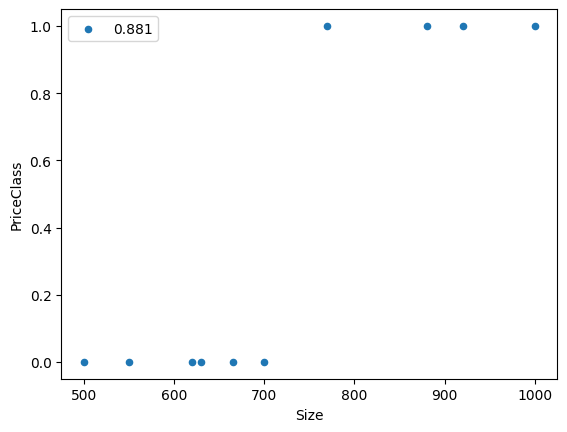

In [12]:
df_classif.plot(kind='scatter', x='Size', y='PriceClass', label="%.3f" % df_classif[['Size', 'PriceClass']].corr().values[0,1])

<Axes: xlabel='BroadbandRate', ylabel='PriceClass'>

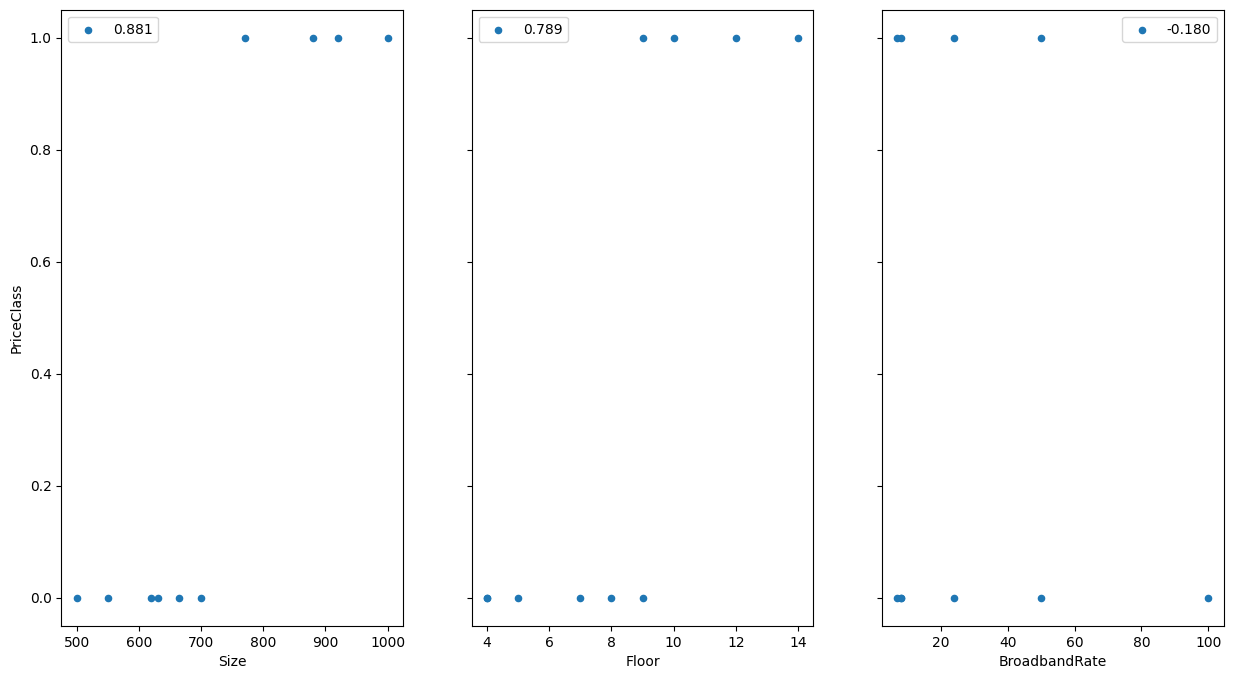

In [13]:
# Scatterplots for each descriptive feature and target feature. 
# Show the correlation value in the plot. In classification, we look for 
# a threshold in the values of an input feature, indicative of the target class.
fig, axs = plt.subplots(1, 3, sharey=True)
df_classif.plot(kind='scatter', x='Size', y='PriceClass', label="%.3f" % df_classif[['Size', 'PriceClass']].corr().values[0,1], ax=axs[0], figsize=(15, 8))
df_classif.plot(kind='scatter', x='Floor', y='PriceClass', label="%.3f" % df_classif[['Floor', 'PriceClass']].corr().values[0,1], ax=axs[1])
df_classif.plot(kind='scatter', x='BroadbandRate', y='PriceClass', label="%.3f" % df_classif[['BroadbandRate', 'PriceClass']].corr().values[0,1], ax=axs[2])

# Linear regression with package <span style="color:red">scikit-learn</span> (applied to a classification problem)

## Simple linear regression (one descriptive feature)


We first apply linear regression to the classification task and look at the outcome. The target feature is the probability of the Price being in class High, also written as p(PriceClass = 1 | Size).

## Simple linear regression for classification
### Training a model

In [14]:
# Prepare the descriptive features
print("\nOriginal dataframe:\n", df.head(10))
cont_features = ['Size']
#cont_features = ['Size', 'Floor', 'BroadbandRate']

X = df_classif[cont_features]
y = df_classif.PriceClass

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Original dataframe:
    ID  Size  Floor  BroadbandRate EnergyRating  RentalPrice
0   1   500      4              8            C          320
1   2   550      7             50            A          380
2   3   620      9              7            A          400
3   4   630      5             24            B          390
4   5   665      8            100            C          385
5   6   700      4              8            B          410
6   7   770     10              7            B          480
7   8   880     12             50            A          600
8   9   920     14              8            C          570
9  10  1000      9             24            B          620

Descriptive features in X:
    Size
0   500
1   550
2   620
3   630
4   665
5   700
6   770
7   880
8   920
9  1000

Target feature in y:
 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: PriceClass, dtype: float64


### Training the model

In [15]:
# Train, aka fit, a model using all continuous features.

linreg = LinearRegression().fit(X[cont_features], y)

# Print the weights learned for each feature.
print("Features: \n", cont_features)
print("\nCoeficients: \n", linreg.coef_)
print("\nIntercept: \n", linreg.intercept_)

Features: 
 ['Size']

Coeficients: 
 [0.00275691]

Intercept: 
 -1.594620772626707


The model learned by fitting a linear regression to the training set using feature Size and interpreting the categorical target feature as a numeric feature with only 2 values: 0 (Price is Low) or 1 (Price is High)

$prob(PriceClass=1|Size) = -1.5946 + 0.0027 * Size$

### Testing the model
Using the trained model to predict the target feature prob(PriceClass=1), given the descriptive feature Size.

In [65]:
# The model learned is: prob(PriceClass=1|Size) = -1.5946 + 0.0027 * Size
# This means that for a unit increase in Size, we have a 0.0027 increase in the probability of the Price being High.
# We can use the learned model to predict the PriceClass for a new office Size.

# The Statsmodels predict() method expects a dataframe object.
# Create a new dataframe with a new test example. 
X_new = pd.DataFrame({'Size': [750]})
X_new.head()

,Size
0,750


In [66]:
# Predict the prob(PriceClass=1|Size) for a new office with Size 750, using the trained model. 
linreg.predict(X_new)

array([0.47305798])

The linear regression model estimates a probability of 0.47 for the Price being in class High, given the Size 750.
If we threshold at 0.5, this means the predicted class is class Low.

### Plotting the trained model

In [18]:
# We can plot the regression line that was estimated from our trainign set.
# First we use the trained model to predict prices for the min and max Size in our dataset.
X_minmax = pd.DataFrame({'Size': [df_classif.Size.min(), df_classif.Size.max()]})
X_minmax.head()


,Size
0,500
1,1000


In [19]:
# Make predictions for the min and max Size values and store them.
linreg_predicted_probs = linreg.predict(X_minmax)
linreg_predicted_probs

array([-0.21616827,  1.16228423])

In [20]:
threshold_line = np.ones(10) * 0.5
threshold_line

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

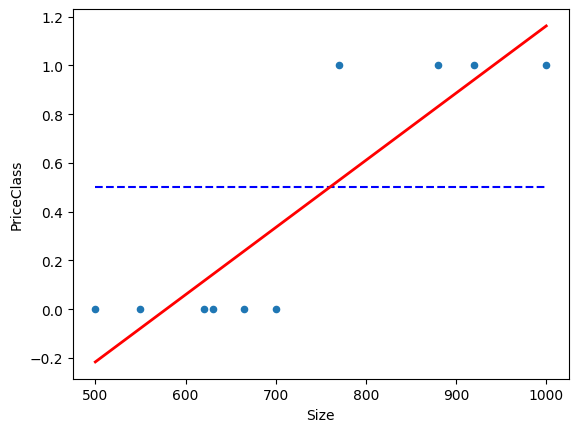

In [21]:
# First, plot the observed data
df_classif.plot(kind='scatter', x='Size', y='PriceClass')

# Plot the threshold line at 0.5 in blue.
plt.plot(df_classif.Size, threshold_line, c='blue', linestyle='dashed')

# Next, plot the regression line, in red. The liear regression estimates are interpreted as probabilities.
plt.plot(X_minmax, linreg_predicted_probs, c='red', linewidth=2)

In [22]:
# Threshod the predicted probs for the min and max Size values and store them.
linreg_predicted_class_Xminmax = (linreg.predict(X_minmax) >= 0.5) * 1.0
linreg_predicted_class_Xminmax

array([0., 1.])

In [23]:
# Threshod the predicted probs for all the 10 examples and store them.
linreg_predicted_class = (linreg.predict(X[cont_features]) >= 0.5) * 1.0
linreg_predicted_class

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])

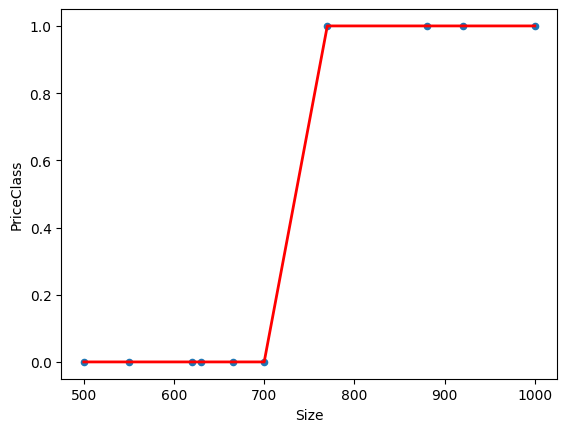

In [24]:
# First, plot the observed data
df_classif.plot(kind='scatter', x='Size', y='PriceClass')

# Plot the threshold line in blue.
#plt.plot(df_classif.Size, threshold_line, c='blue', linestyle='dashed')

# Plot the linear regression class estimation, in red.
plt.plot(df_classif.Size, linreg_predicted_class, c='red', linewidth=2)

# Logistic Regression for Classification using package <span style="color:red">scikit-learn</span>
## Training a model for predicting PriceClass using feature Size


In [25]:
# Train, aka fit, a logistic regression model using all continuous features.

logreg = LogisticRegression().fit(X[cont_features], y)

# Print the weights learned for each feature.
print("Features: \n", cont_features)
print("\nCoeficients: \n", logreg.coef_)
print("\nIntercept: \n", logreg.intercept_)

Features: 
 ['Size']

Coeficients: 
 [[0.17172472]]

Intercept: 
 [-126.21889894]


The estimated logistic regression model is $prob(PriceClass=1|Size)=\frac{1}{1 +e ^ -({-126.21889894 + 0.17172472 * Size})}$

## Testing the model

In [26]:
X_new

,Size
0,750


The logistic regression model estimates a probability of 0.92 for the Price being in class High, given the Size of 750. This can also be written as 

$prob(Price=1|Size=750)=\frac{1}{1 +e ^ -({-126.21889894 + 0.17172472 * Size})} = \frac{1}{1+e ^ -{2.57464106}} = 0.92921161$.

In [27]:
# Predict the prob(Price=1|Size) for a new office with Size 750, using the trained model. 
# Print the predicted probabilities for each class. The first column is 
# the predicted probability for class Low, the second column for class High.
logreg.predict_proba(X_new)

array([[0.07078839, 0.92921161]])

In [28]:
# Print the predicted class based on thresholding the probability for class High at 0.5.
logreg.predict(X_new)

array([1.])

## Ploting the trained model

In [29]:
print("Toy data frame X_minmax:\n", X_minmax)

# Make predictions for all the points in the training data and store them.
logreg_predictions = logreg.predict(X_minmax)
print("\nPredicted probs for both classes on X_minmax:\n", logreg.predict_proba(X_minmax))
print("\nPredicted probs only for positive class on on X_minmax:", logreg.predict_proba(X_minmax)[:,1])
print("\nPredicted classes:", logreg_predictions)

Toy data frame X_minmax:
    Size
0   500
1  1000

Predicted probs for both classes on X_minmax:
 [[1.00000000e+00 2.97425318e-18]
 [0.00000000e+00 1.00000000e+00]]

Predicted probs only for positive class on on X_minmax: [2.97425318e-18 1.00000000e+00]

Predicted classes: [0. 1.]



Predicted probs on full training data:
 [[1.00000000e+00 2.97425318e-18]
 [1.00000000e+00 1.59342953e-14]
 [9.99999997e-01 2.64770597e-09]
 [9.99999985e-01 1.47455418e-08]
 [9.99993989e-01 6.01072113e-06]
 [9.97555811e-01 2.44418931e-03]
 [2.45019166e-03 9.97549808e-01]
 [1.53661528e-11 1.00000000e+00]
 [1.59872116e-14 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]]

Predicted class on full training data:
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


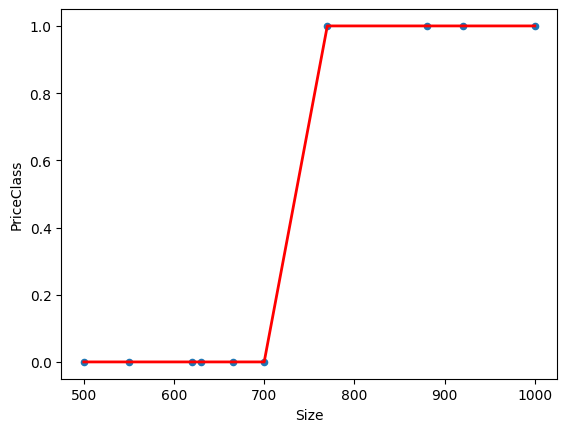

In [30]:
# First, plot the observed data
df_classif.plot(kind='scatter', x='Size', y='PriceClass')

print("\nPredicted probs on full training data:\n", logreg.predict_proba(X[cont_features]))
print("\nPredicted class on full training data:\n", logreg.predict(X[cont_features]))

# Plot the logistic regression class estimation, in red.
#plt.plot(df_classif.Size, threshold_line, c='blue', linestyle='dashed')

# Plot the logistic regression class estimation, in red.
plt.plot(df_classif.Size, logreg.predict(X[cont_features]), c='red', linewidth=2)



## Comparing Linear Regression to Logistic Regression trained models

Model learned using linear regression:

$p(PriceClass=1|Size) = -1.594621 + 0.002757 * Size$

Predicting on new test example with Size=750:

$p(PriceClass=1|Size=750) = -1.594621 + 0.002757 * 750 = 0.473129$


Model learned using logistic regression:

$prob(PriceClass=1|Size)=\frac{1}{1 +e ^ -({-126.21889894 + 0.17172472 * Size})}$

Predicting on new test example with Size=750:

$prob(Price=1|Size=750)=\frac{1}{1 +e ^ -({-126.21889894 + 0.17172472 * 750})} = \frac{1}{1+e ^ -{2.57464106}} = 0.92921161$.

We see that the probability estimates for the two methods are quite different, linear regression estimates the probability of the Price being High at 0.4731 versus logistic regression 0.9292.



In [31]:
# Example of doing manual computations
import math
print("Linear regression prediction:", -1.594621 + 0.002757 * 750)
print("Logistic regression prediction: ", 1/(1+ math.e ** -(-126.21889894 + 0.17172472 * 750)))

Linear regression prediction: 0.4731289999999997
Logistic regression prediction:  0.9292115816344748


## Testing the model (using the model to make predictions)

In [32]:
# Predicted probabilities for each example. 
# The output is a pair for each example, 
# The first component is the probability of the negative class (class 0).
# The second component is the probability of the positive class (class 1).
logreg_predicted_probs = logreg.predict_proba(X[cont_features])

In [33]:
# Predict using the trained model, on in-sample data (same sample used for training and test)
logreg_predicted_class = logreg.predict(X[cont_features])
print("Predictions: ", logreg_predicted_class)

Predictions:  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [34]:
# Check the accuracy on the training set. 
# The accuracy is the ratio of correct predictions to total examples
# In our case we have 10 examples and the predictions is correct on 9 of them.
# Total accuracy is then 9/10 = 0.9 or 90% accuracy
logreg.score(X[cont_features], y)

1.0

## Multiple logistic regression (using more than one feature)
### Training the model

In [35]:
# Prepare the descriptive features
print("\nOriginal dataframe:\n", df.head(10))
#cont_features = ['Size']
cont_features = ['Size', 'Floor', 'BroadbandRate']

X = df_classif[cont_features]
y = df_classif.PriceClass

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Original dataframe:
    ID  Size  Floor  BroadbandRate EnergyRating  RentalPrice
0   1   500      4              8            C          320
1   2   550      7             50            A          380
2   3   620      9              7            A          400
3   4   630      5             24            B          390
4   5   665      8            100            C          385
5   6   700      4              8            B          410
6   7   770     10              7            B          480
7   8   880     12             50            A          600
8   9   920     14              8            C          570
9  10  1000      9             24            B          620

Descriptive features in X:
    Size  Floor  BroadbandRate
0   500      4              8
1   550      7             50
2   620      9              7
3   630      5             24
4   665      8            100
5   700      4              8
6   770     10              7
7   880     12             50
8   920     14     

In [36]:
# Use more features for training
# Train aka fit, a model using all continuous features.
multiple_logreg = LogisticRegression().fit(X[cont_features], y)

# Print the weights learned for each feature.
print("Features: \n", cont_features)
print("Coeficients: \n", multiple_logreg.coef_)
print("\nIntercept: \n", multiple_logreg.intercept_)

Features: 
 ['Size', 'Floor', 'BroadbandRate']
Coeficients: 
 [[ 0.17060582  0.01459199 -0.00289444]]

Intercept: 
 [-125.47669839]


## Testing the multiple logreg model (using the model to make predictions)

In [37]:
# Predicted probabilities for each example. 
# The output is a pair for each example, 
# The first component is the probability of the negative class (class 0).
# The second component is the probability of the positive class (class 1).
multiple_logreg_predicted_probs = multiple_logreg.predict_proba(X[cont_features])

In [38]:
# Predict using the trained model, on in-sample data (same sample used for training and test)
multiple_logreg_predicted_class = multiple_logreg.predict(X[cont_features])
print("Predictions: ", multiple_logreg_predicted_class)

Predictions:  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [39]:
# Check the accuracy on the training set. 
multiple_logreg.score(X[cont_features], y)

1.0

## Classification Evaluation Metrics

In [40]:
print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
    Size  Floor  BroadbandRate
0   500      4              8
1   550      7             50
2   620      9              7
3   630      5             24
4   665      8            100
5   700      4              8
6   770     10              7
7   880     12             50
8   920     14              8
9  1000      9             24

Target feature in y:
 0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: PriceClass, dtype: float64


In [41]:
# Some more evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(y, multiple_logreg_predicted_class))
print("Confusion matrix: \n", metrics.confusion_matrix(y, multiple_logreg_predicted_class))
print("Classification report:\n ", metrics.classification_report(y, multiple_logreg_predicted_class))


Accuracy:  1.0
Confusion matrix: 
 [[6 0]
 [0 4]]
Classification report:
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



## Model evaluation on out-of-sample data (keep 70% examples for training and 30% for test)

In [42]:
print(X)
print(y)

   Size  Floor  BroadbandRate
0   500      4              8
1   550      7             50
2   620      9              7
3   630      5             24
4   665      8            100
5   700      4              8
6   770     10              7
7   880     12             50
8   920     14              8
9  1000      9             24
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: PriceClass, dtype: float64


In [43]:
# Split the data into train and test sets
# Take a third (random) data samples as test data, rest as training data
# Note that this training set if very small and the model will not be very reliable due to this sample size problem.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# The random_state parameter allows us to fix the split so the result doesn't change in different runs of the code
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


print("Training data:\n", pd.concat([X_train, y_train], axis=1))
print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

Training data:
    Size  Floor  BroadbandRate  PriceClass
5   700      4              8         0.0
0   500      4              8         0.0
2   620      9              7         0.0
7   880     12             50         1.0
1   550      7             50         0.0

Test data:
    Size  Floor  BroadbandRate  PriceClass
9  1000      9             24         1.0
4   665      8            100         0.0
6   770     10              7         1.0
3   630      5             24         0.0
8   920     14              8         1.0


In [44]:
# Train on the training sample and test on the test sample.
logreg_train = LogisticRegression().fit(X_train, y_train)
# Print the weights learned for each feature.
# Print the weights learned for each feature.
print("Features: \n", cont_features)
print("\nCoeficients: \n", logreg_train.coef_)
print("\nIntercept: \n", logreg_train.intercept_)

Features: 
 ['Size', 'Floor', 'BroadbandRate']

Coeficients: 
 [[0.08105625 0.00359688 0.01890004]]

Intercept: 
 [-64.61217932]


In [45]:
# Estimated class probabilities on test set
print(logreg_train.predict_proba(X_test))

[[4.43990615e-08 9.99999956e-01]
 [9.99847926e-01 1.52073978e-04]
 [8.83972091e-01 1.16027909e-01]
 [9.99997903e-01 2.09667858e-06]
 [3.86420476e-05 9.99961358e-01]]


In [46]:
# Estimated classes  on test set
y_predicted = logreg_train.predict(X_test)
print(y_predicted)

[1. 0. 0. 0. 1.]


In [47]:
# Some more evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(y_test, y_predicted))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, y_predicted))
print("Classification report:\n ", metrics.classification_report(y_test, y_predicted))

Accuracy:  0.8
Confusion matrix: 
 [[2 0]
 [1 2]]
Classification report:
                precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [48]:
print(metrics.accuracy_score(y_test, y_predicted))

0.8


In [49]:
print(metrics.f1_score(y_test, y_predicted))

0.8


## Model evaluation using cross-validation (several out-of-sample datasets with a 70% train and 30% test split)

In [50]:
X

,Size,Floor,BroadbandRate
0,500,4,8
1,550,7,50
2,620,9,7
3,630,5,24
4,665,8,100
5,700,4,8
6,770,10,7
7,880,12,50
8,920,14,8
9,1000,9,24


In [51]:
y

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: PriceClass, dtype: float64

In [52]:
#?cross_val_score

In [53]:
# Evaluate the model using 3-fold cross-validation.
# Uses 2 thirds of data for training and the last third for testing. 
# This process is repeated 3 times. More details about cross-validation here: http://www-bcf.usc.edu/~gareth/ISL/
scores = cross_val_score(LogisticRegression(), X, y, scoring='f1', cv=3)
print("\nF1 CV scores:", scores)
print("\nF1 CV mean score:",scores.mean())
print("\nF1 CV std score:",scores.std())


F1 CV scores: [0.66666667 1.         1.        ]

F1 CV mean score: 0.8888888888888888

F1 CV std score: 0.15713484026367724


In [54]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=3)
print("\nAcc CV scores:", scores)
print("\nAcc CV mean score:", scores.mean())
print("\nAcc CV std score:", scores.std())


Acc CV scores: [0.75 1.   1.  ]

Acc CV mean score: 0.9166666666666666

Acc CV std score: 0.11785113019775792
